In [1]:
from PIL import Image
import glob
import re
from random import *
from os import listdir
from pickle import dump
from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
import numpy as np
from keras.models import Model
from keras.models import load_model
from numpy import argmax
import cv2
import matplotlib.pyplot as plt
from keras.layers import Bidirectional
import cv2
from keras import optimizers
import networkx as nx
import sys
from datetime import datetime
import pandas as pd
import plotly.express as px

Using TensorFlow backend.


# ***Building Graph***

In [2]:
def creating_a_graphs(data,preposition):
  #creating a  dictionary of the preposition, conecting word and noun
  data_dict = {}
  dictionary_of_graphs = {}
  for x in range(len(data)):
    New_data = []
    if(data[x] in preposition):
      New_data.append(data[x-1])
      New_data.append(data[x+1])
      data_dict[data[x]+"-"+str(x)] = New_data

  print(data_dict)
  #creating a graph with nouns as nodes and preposition as edges
  G=nx.DiGraph()
  for key,value in data_dict.items():
    G.add_nodes_from(value)
    G.add_edge(value[0],value[1])
    G.edges[value[0],value[1]]["prep"] = key

  #dictionary_of_graphs[time_stamp] = G


  #plotting the grap with nodes and edges as tags
  node_color = [G.degree(v) for v in G]  
  node_size = 1100
  edge_width = 0.3
  
  pos = nx.planar_layout(G)

  nx.draw_networkx(G, pos,node_size = node_size,  
                   node_color = node_color, alpha = 0.7, 
                   with_labels = True, width = edge_width, 
                   edge_color ='.4', cmap = plt.cm.Blues) 

  node_labels = nx.get_node_attributes(G,'prep')
  nx.draw_networkx_labels(G, pos, labels = node_labels)
  edge_labels = nx.get_edge_attributes(G,'prep')
  nx.draw_networkx_edge_labels(G, pos, labels = edge_labels)
  
  
  plt.axis('off') 
  plt.tight_layout()
  plt.show()
  
  return  G

# ***Helper Functions***

In [3]:
def extract_features_test(filename):
	# load the model
	model = VGG19()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [4]:
def extract_features_test_video(image):
	# load the model
	model = VGG19()
	# re-structure the model
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = cv2.resize(image, (224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [5]:
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

In [6]:
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [7]:
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 

In [8]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text


# load clean descriptions into memory
def load_clean_descriptions(filename):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		# create list
		if image_id not in descriptions:
			descriptions[image_id] = list()
		# wrap description in tokens
		desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
		# store
		descriptions[image_id].append(desc)
	return descriptions

# ***Creating tokenizer***

In [9]:
# Loading text
train_descriptions = load_clean_descriptions('../Description_Text/youtube_video_img2_train.txt')
print('Descriptions: train=%d' % len(train_descriptions))

# Tokenizing Text
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Descriptions: train=17066
Vocabulary Size: 60
Description Length: 9


# ***Evaluation Fucntion***

In [10]:
def evaluate_model(predicted,path):
  BLEU_1_total = 0
  BLEU_2_total = 0
  BLEU_3_total = 0
  BLEU_4_total = 0
  actual = []
  i = 0
  description = load_clean_descriptions(path)
  for key,desc_list in description.items():
    # store acutual and predicted
    references = [d.split() for d in description]
    actual.append(references)
    BLEU_1_total += corpus_bleu([actual[i]],[predicted[i]],weights = (1.0,0,0,0))
    BLEU_2_total += corpus_bleu([actual[i]],[predicted[i]],weights = (0.5,0.5,0,0))
    BLEU_3_total += corpus_bleu([actual[i]],[predicted[i]],weights = (0.3,0.3,0,3,0))
    BLEU_4_total += corpus_bleu([actual[i]],[predicted[i]],weights = (0.25,0.25,0.25,0.25))
    i += 1

  print("BLUE-1 {}".format( BLEU_1_total/i+1))
  print("BLUE-2 {}".format( BLEU_2_total/i+1))
  print("BLUE-3 {}".format( BLEU_3_total/i+1))
  print("BLUE-4 {}".format( BLEU_4_total/i+1))

# ***Counting Frames***


In [11]:
def time_Per_Picture(path):

  video = cv2.VideoCapture(path);
      
  # Find OpenCV version
  (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
      
  if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print ("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
  else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print ("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
      
  video.release();
  time = 1000/fps 
  print("{0} ms".format(time))
  return time 

In [12]:
import os 
from pprint import pprint 

files = []
for dirname, dirnames, filenames in os.walk('../NewImage'):

    # print path to all filenames.
    for filename in filenames:
        files.append( filename)




In [13]:
time_per_pic = time_Per_Picture('../Video/JeansManufacturingUnit.mp4')

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.97002997002997
33.36666666666667 ms


# ***Predicting***

/home/nsu_ecedl/.local/lib/python3.5/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



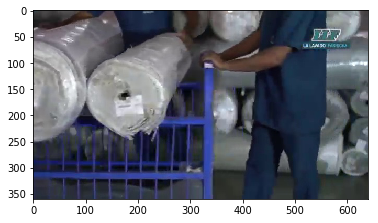

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


/usr/local/lib/python3.5/dist-packages/networkx/drawing/layout.py:950: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



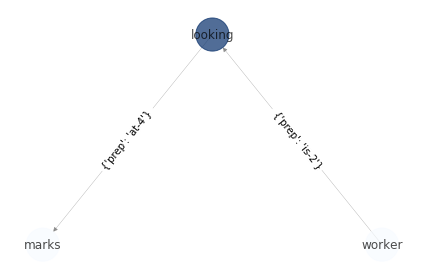

time - taken 0:00:04.342706
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 0]}
startseq worker is looking at marks endseq


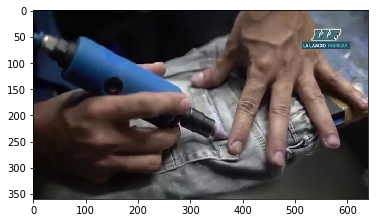

{'a-2': ['ironning', 'cloth']}


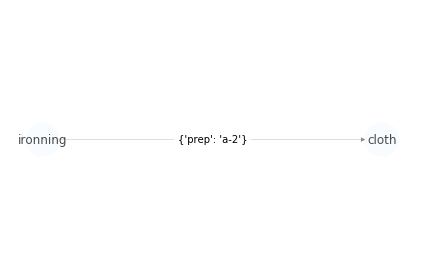

time - taken 0:00:03.639086
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 0]}
startseq ironning a cloth endseq


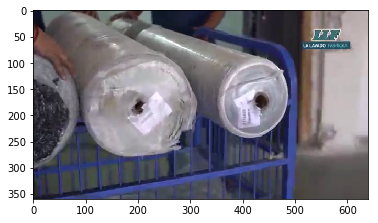

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


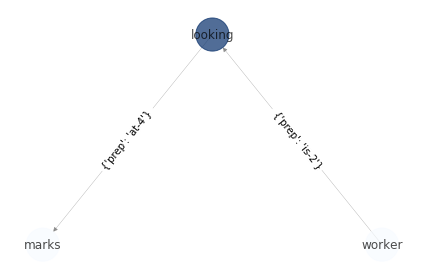

time - taken 0:00:03.708085
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 0]}
startseq worker is looking at marks endseq


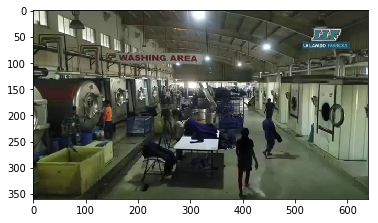

{'for-4': ['clothes', 'coloring'], 'the-2': ['spot', 'clothes']}


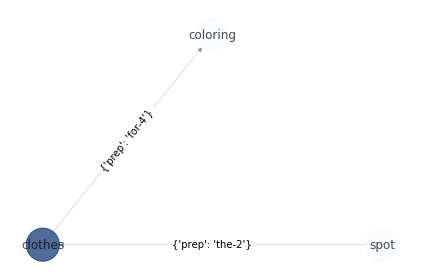

time - taken 0:00:03.770617
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 0]}
startseq spot the clothes for coloring endseq


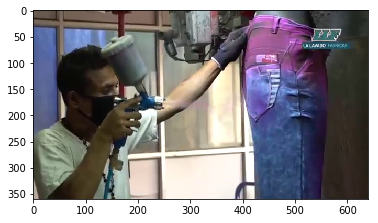

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


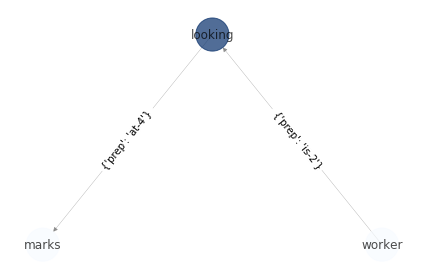

time - taken 0:00:03.992579
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 0]}
startseq worker is looking at marks endseq


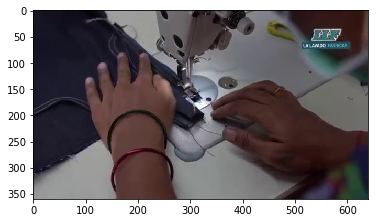

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


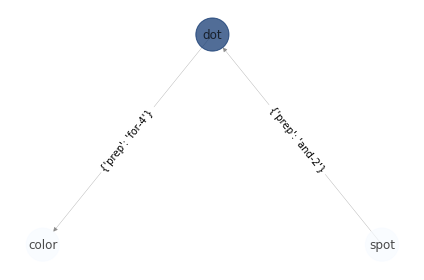

time - taken 0:00:03.732379
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 0]}
startseq spot and dot for color endseq


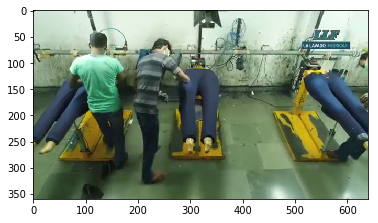

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


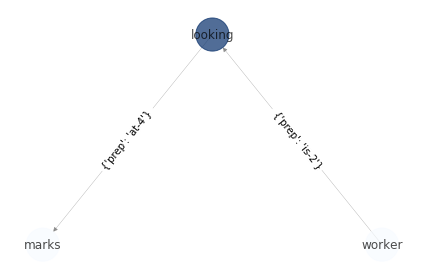

time - taken 0:00:03.867816
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 0]}
startseq worker is looking at marks endseq


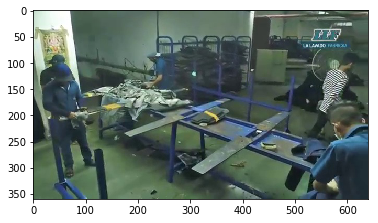

time - taken 0:00:03.562321
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 33.36666666666667]}
startseq worker is looking at marks endseq


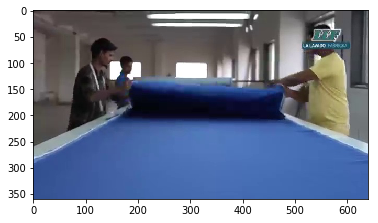

{'the-4': ['cutting', 'fabric'], 'with-6': ['fabric', 'machine'], 'is-2': ['worker', 'cutting']}


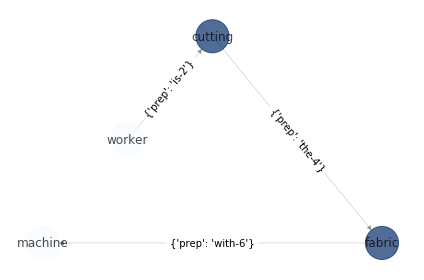

time - taken 0:00:03.727605
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 0]}
startseq worker is cutting the fabric with machine endseq


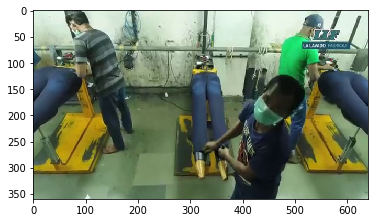

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


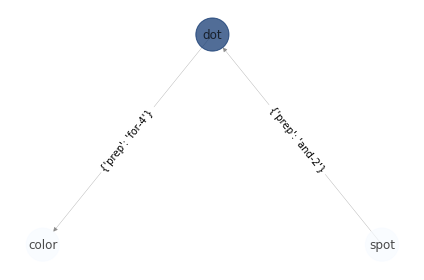

time - taken 0:00:03.666134
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 0]}
startseq spot and dot for color endseq


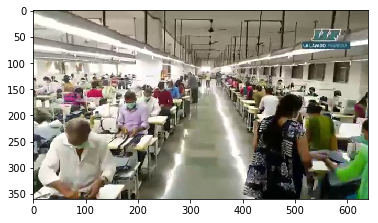

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


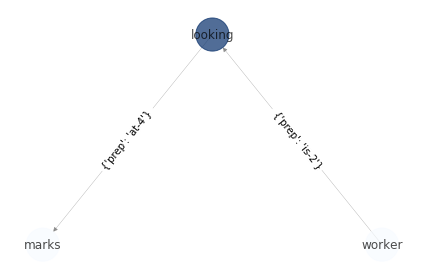

time - taken 0:00:03.732289
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 0]}
startseq worker is looking at marks endseq


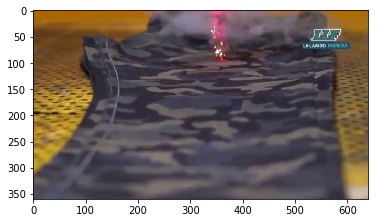

{'the-4': ['cutting', 'fabric'], 'with-6': ['fabric', 'machine'], 'is-2': ['worker', 'cutting']}


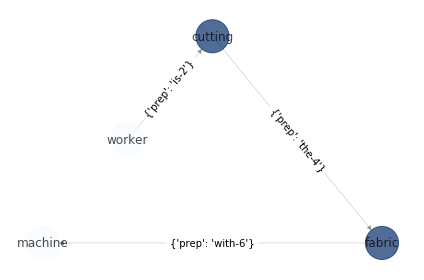

time - taken 0:00:03.781304
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 0]}
startseq worker is cutting the fabric with machine 

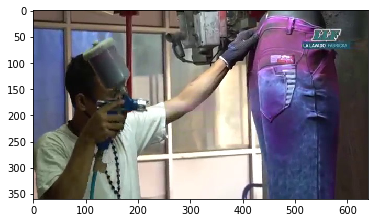

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


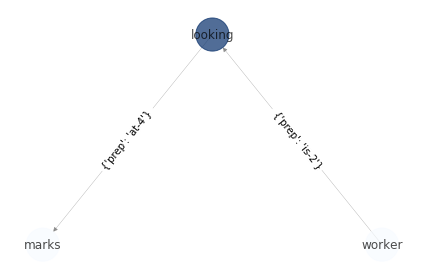

time - taken 0:00:03.787223
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

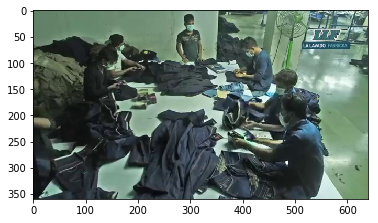

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


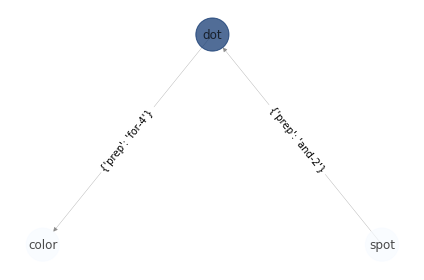

time - taken 0:00:03.723459
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

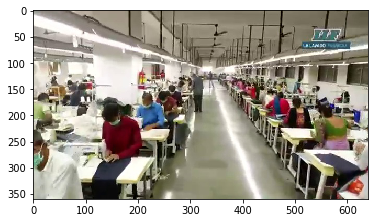

{'and-4': ['fabric', 'fabric'], 'on-6': ['fabric', 'table'], 'on-2': ['roller', 'fabric']}


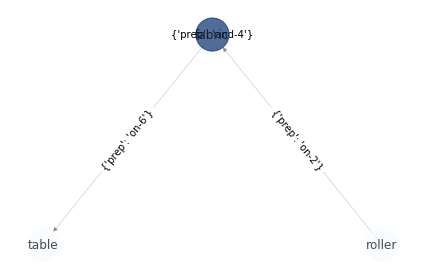

time - taken 0:00:03.793895
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

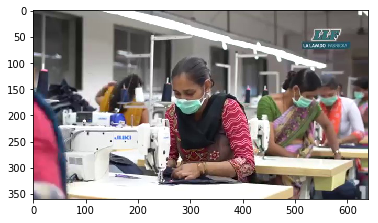

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


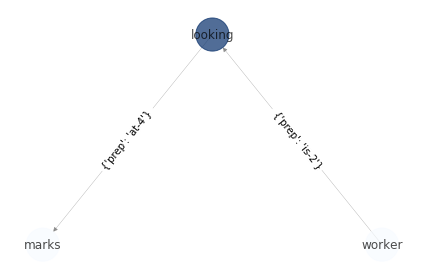

time - taken 0:00:03.695597
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

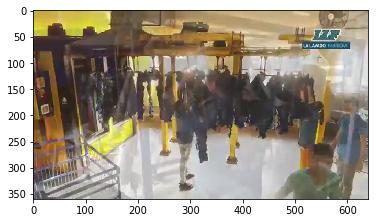

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


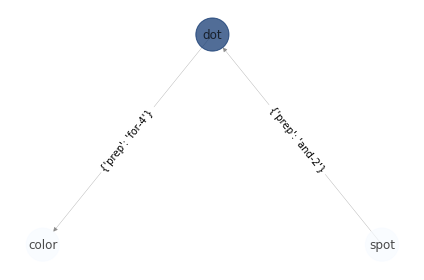

time - taken 0:00:03.771639
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

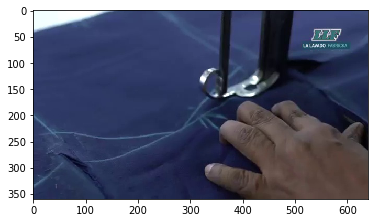

{'by-6': ['machine', 'worker'], 'with-4': ['sown', 'machine']}


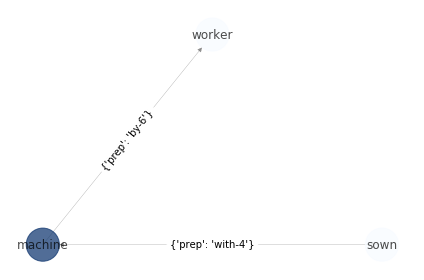

time - taken 0:00:04.039988
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

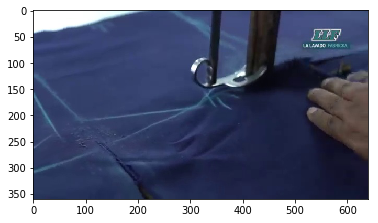

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


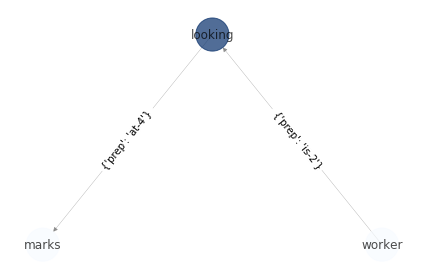

time - taken 0:00:03.753830
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

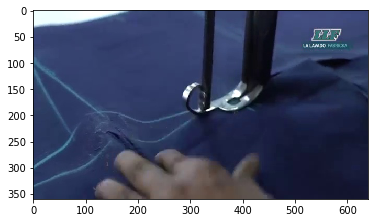

time - taken 0:00:03.661343
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

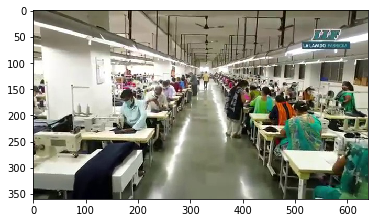

time - taken 0:00:03.447334
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

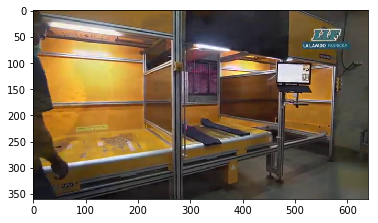

time - taken 0:00:03.504648
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

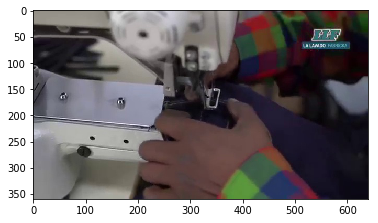

{'by-6': ['machine', 'worker'], 'with-4': ['sown', 'machine']}


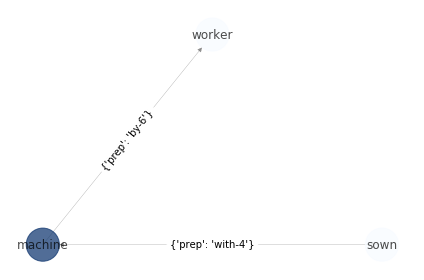

time - taken 0:00:03.978413
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

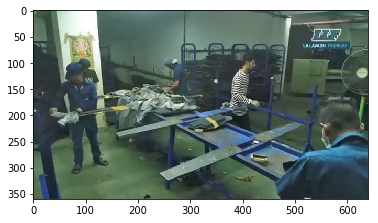

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


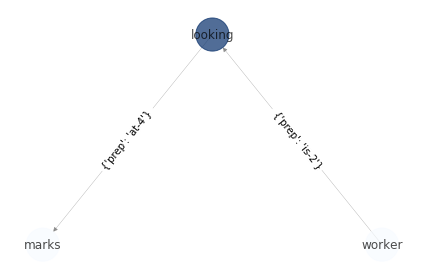

time - taken 0:00:03.847455
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

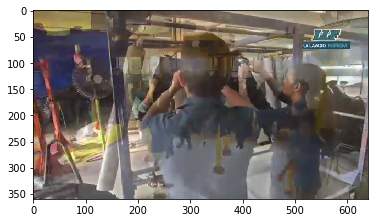

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


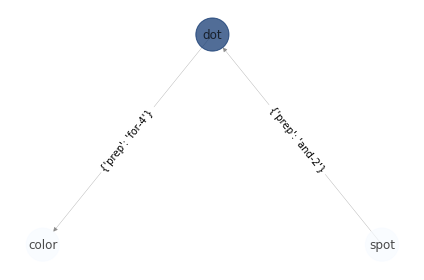

time - taken 0:00:03.663687
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

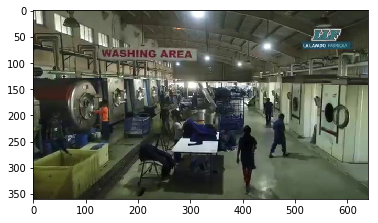

time - taken 0:00:03.544354
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

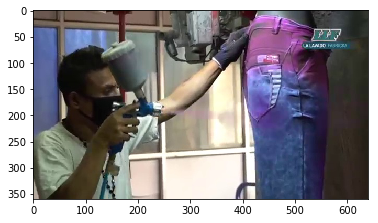

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


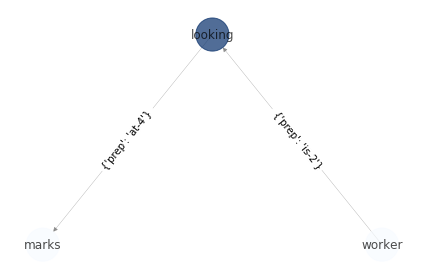

time - taken 0:00:03.699737
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

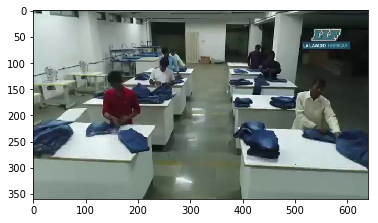

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


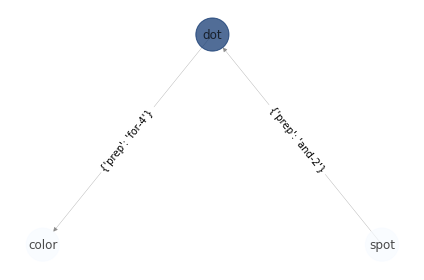

time - taken 0:00:03.787679
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

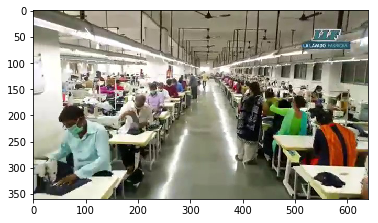

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


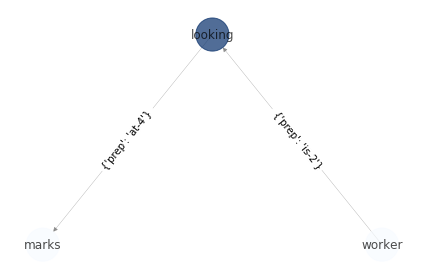

time - taken 0:00:03.697879
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

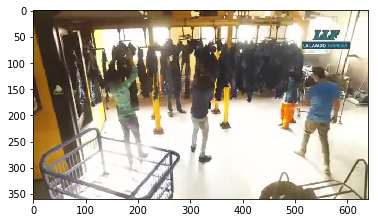

{'the-4': ['cutting', 'fabric'], 'with-6': ['fabric', 'machine'], 'is-2': ['worker', 'cutting']}


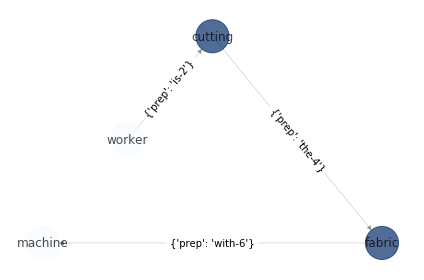

time - taken 0:00:03.670681
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

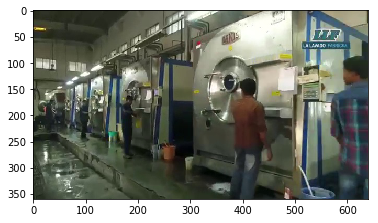

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


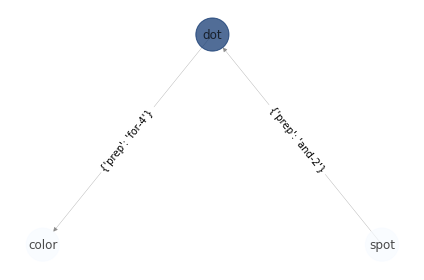

time - taken 0:00:03.691986
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

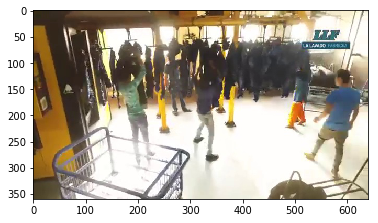

time - taken 0:00:03.528887
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

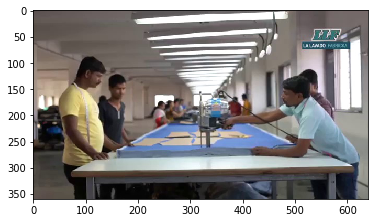

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


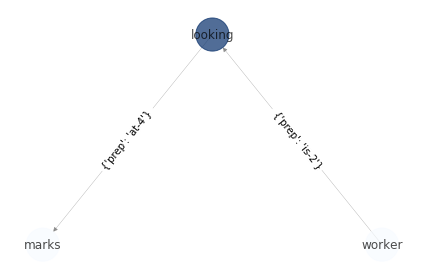

time - taken 0:00:04.149384
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

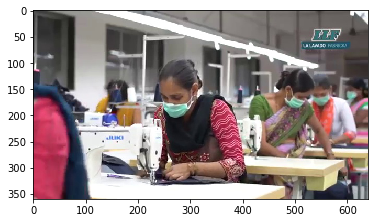

time - taken 0:00:03.509454
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

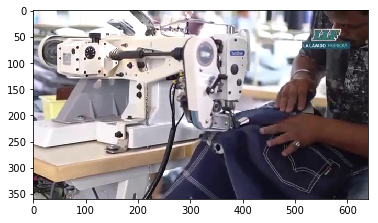

{'by-6': ['machine', 'worker'], 'with-4': ['sown', 'machine']}


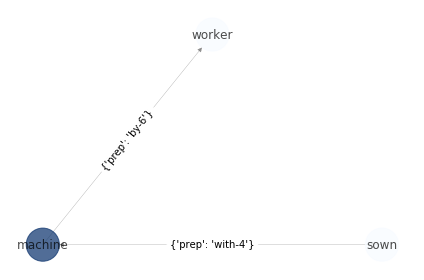

time - taken 0:00:03.731147
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

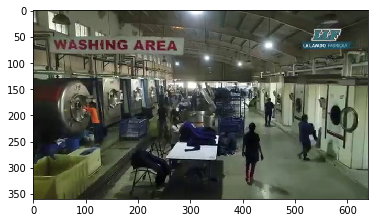

{'for-4': ['dot', 'color'], 'and-2': ['spot', 'dot']}


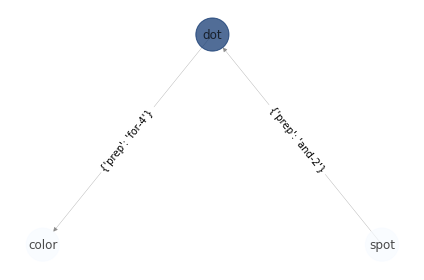

time - taken 0:00:03.903236
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

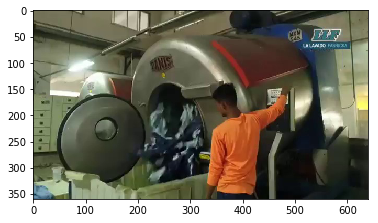

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


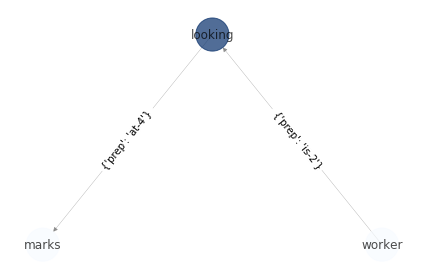

time - taken 0:00:03.681571
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

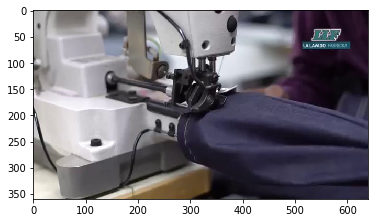

{'by-6': ['machine', 'worker'], 'with-4': ['sown', 'machine']}


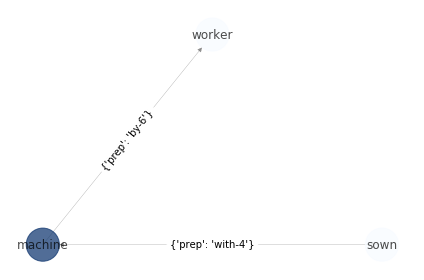

time - taken 0:00:03.650548
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

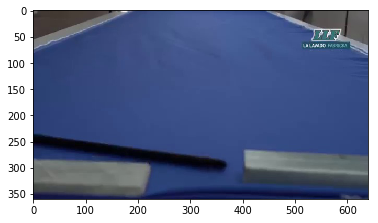

{'for-4': ['clothes', 'coloring'], 'the-2': ['spot', 'clothes']}


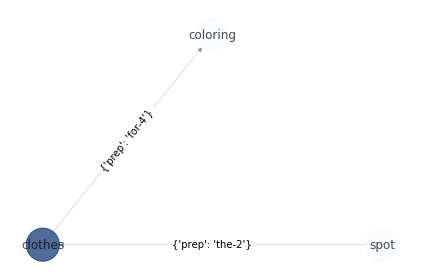

time - taken 0:00:03.713761
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

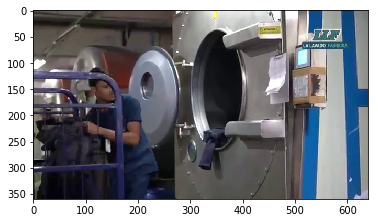

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


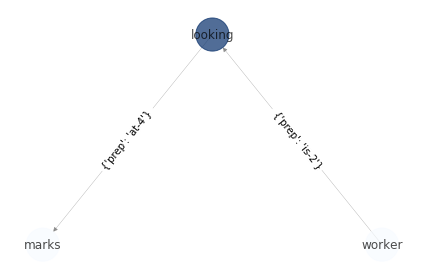

time - taken 0:00:03.880002
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

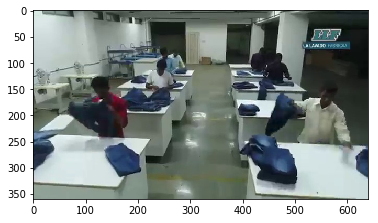

{'for-4': ['clothes', 'coloring'], 'the-2': ['spot', 'clothes']}


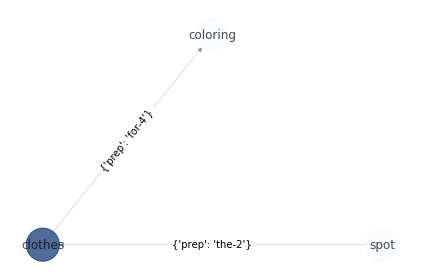

time - taken 0:00:03.715919
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

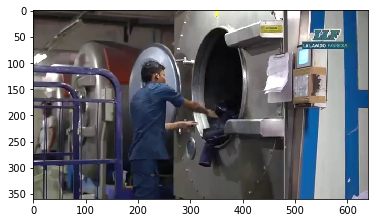

{'at-4': ['looking', 'marks'], 'is-2': ['worker', 'looking']}


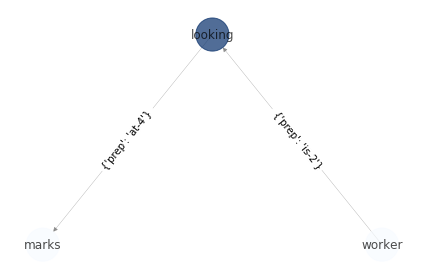

time - taken 0:00:03.720378
{0: [<networkx.classes.digraph.DiGraph object at 0x7f20a25c2080>, 33.36666666666667], 1: [<networkx.classes.digraph.DiGraph object at 0x7f20a00612e8>, 33.36666666666667], 2: [<networkx.classes.digraph.DiGraph object at 0x7f20906f6a20>, 33.36666666666667], 3: [<networkx.classes.digraph.DiGraph object at 0x7f20906397f0>, 33.36666666666667], 4: [<networkx.classes.digraph.DiGraph object at 0x7f2090721278>, 33.36666666666667], 5: [<networkx.classes.digraph.DiGraph object at 0x7f20a0062860>, 33.36666666666667], 6: [<networkx.classes.digraph.DiGraph object at 0x7f2090720400>, 66.73333333333333], 7: [<networkx.classes.digraph.DiGraph object at 0x7f2090521ef0>, 33.36666666666667], 8: [<networkx.classes.digraph.DiGraph object at 0x7f2090466a58>, 33.36666666666667], 9: [<networkx.classes.digraph.DiGraph object at 0x7f20903a7748>, 33.36666666666667], 10: [<networkx.classes.digraph.DiGraph object at 0x7f20902e8588>, 33.36666666666667], 11: [<networkx.classes.digraph.DiGr

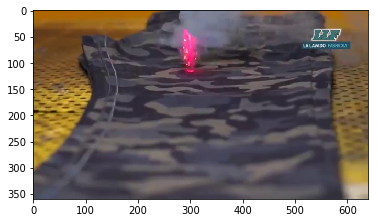

KeyboardInterrupt: 

In [14]:
max_length = 9
Array_of_description = None
dictionary_of_graphs = {}
preposition = ["below","above","and","on","over",'holds','has','up','in','is','of','as','for','by','the','with','was','have','at','a']
counter = 0
time = 0
image_position = 1
predicted_values = []
# load the model
model = load_model('../Models/model-ep136-loss0.096-val_loss0.108_VGG19_new_img2.h5')
# load and prepare the photograph
for filename in glob.glob('../Test/*.jpg'):
  # start time  
  start = datetime.now()               
  # opening images  
  img=Image.open(filename)                                                                                                                         
  Unique = int(re.sub("\D", "", filename ))         
  #picRand = str(randint(0,20))
  
  Pictures =Image.open('../Test/'+str(Unique)+'.jpg')
  plt.imshow(Pictures)
  plt.show()
  
  # extracting features
  photo = extract_features_test('../Test/'+str(Unique)+'.jpg')
  
  # generate description
  description = generate_desc(model, tokenizer, photo, max_length)
  data = description.split()
  predicted_values.append(data)
  if(counter - 1 >= 0 ):
    dictionary_of_graphs[counter-1][1] += time_per_pic
 

  # checking duplicate prediction
  if(description != Array_of_description ):
    dictionary_of_graphs[counter] = [creating_a_graphs(data,preposition),0]
    counter += 1
    time = 0
    Array_of_description = description
  
  # stop time
  stop = datetime.now()
  print("time - taken", stop - start)

  # image_position +=3
  print(dictionary_of_graphs)
  print(description)

# ***Evaluation***

In [ ]:
evaluate_model(predicted_values,'../Description_Text/youtube_video_work_env_test.txt')

In [ ]:
work_time_dst =  pd.read_csv("../video_data_work_time_dist.csv", sep='\t',index_col=False) 

In [ ]:
work_time_dst.drop(['Unnamed: 0'], axis = 1)

In [ ]:
fig = px.histogram(work_time_dst, x=" work ",y="Time ", histfunc='avg')
fig.show()

# ***Translating the pictures for a dictionary***

In [ ]:

max_length = 10
# load the model
model = load_model('/content/drive/My Drive/Colab_Notebooks/model-ep007-loss0.118-val_loss0.369_VGG16.h5')

Map_of_pic = {}

temp = None

seq = 0

vidcap = cv2.VideoCapture('/content/drive/My Drive/Colab_Notebooks/VID3.mp4')
fps = vidcap.get(cv2.CAP_PROP_FPS)
success,image = vidcap.read()
count = 0

while success:
  # dividing the video into franes
  success,image = vidcap.read()
  # extracting features from photo
  photo = extract_features_test_video(image)
  print('Read a new frame: ', success)
  count += 1
  # calculating time per frame
  time = count/fps
  # generating caption
  description = generate_desc(model, tokenizer, photo, max_length)
  print(description)
  #
  if description != temp and temp == None:
      Map_of_pic[seq] = [description,time]
      seq = seq + 1  
  
  temp = description

print(Map_of_pic)
cam.release() 
cv2.destroyAllWindows()

In [ ]:


vidcap = cv2.VideoCapture('testing.mp4')
fps = vidcap.get(cv2.CAP_PROP_FPS)
success,image = vidcap.read()
count = 0
success = True

    while success:
        success,frame = vidcap.read()
        count+=1
        print("time stamp current frame:",count/fps)